In [ ]:
import math
import multiprocessing
import os
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import scipy.ndimage
import skimage.color
import sklearn.cluster
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from tqdm.autonotebook import tqdm

## 16-720 Computer Vision: Homework 1 (Spring 2022)
## Spatial Pyramid Matching for Scene Classification

In [ ]:
class Opts(object):
    def __init__(
        self,
        data_dir="../data",
        feat_dir="../feat",
        out_dir=".",
        filter_scales=(1, 2),
        K=10,
        alpha=25,
        L=1,
    ):
        '''
        Manage tunable hyperparameters.

        You can also add your own additional hyperparameters.

        [input]
        * data_dir: Data directory.
        * feat_dir: Feature directory.
        * out_dir: Output directory.
        * filter_scales: A list of scales for all the filters.
        * K: Number of words.
        * alpha: Subset of alpha pixels in each image.
        * L: Number of layers in spatial pyramid matching (SPM).

        '''
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.out_dir = out_dir
        self.filter_scales = list(filter_scales)
        self.K = K
        self.alpha = alpha
        self.L = L

opts = Opts()

In [ ]:
# utils

def get_num_CPU():
    '''
    Counts the number of CPUs available in the machine.
    '''
    return multiprocessing.cpu_count()


def display_filter_responses(opts, response_maps):
    '''
    Visualizes the filter response maps.

    [input]
    * response_maps: a numpy.ndarray of shape (H,W,3F)
    '''

    n_scale = len(opts.filter_scales)
    plt.figure()

    for i in range(n_scale * 4):
        plt.subplot(n_scale, 4, i + 1)
        resp = response_maps[:, :, i * 3:i * 3 + 3]
        resp_min = resp.min(axis=(0, 1), keepdims=True)
        resp_max = resp.max(axis=(0, 1), keepdims=True)
        resp = (resp - resp_min) / (resp_max - resp_min)
        plt.imshow(resp)
        plt.axis("off")

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95,
                        bottom=0.05, wspace=0.05, hspace=0.05)
    plt.show()


def visualize_wordmap(original_image, wordmap, out_path=None):
    fig = plt.figure(figsize=(12.8, 4.8))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(original_image)
    plt.axis("off")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(wordmap)
    plt.axis("off")
    plt.show()
    if out_path:
        plt.savefig(out_path, pad_inches=0)


## Question 1

## Q1.1.1


Gaussian Filters are used to blur an image while retaining large scale, prominent features. Laplacian filters are used for 'blob' detections, that is, to detect areas of high brightness surrounded by low brightness, or vice versa. Gaussian derivatives in the $x$ direction detect changes in intensity along the $x$ direction, which corresponds to vertically oriented edges. Similarly, Gaussian derivative filters in the $y$ direction detects changes in intensity along the $y$ direction, which corresponds to horizontally oriented edges. By including multiple scales of filter responses, we can isolate features of varying scales in the target image as well- by selecting too 'big' of a Gaussian filter we may blur some of the finer features we may wish to retain or vice versa. Filter scaling allows us to retain, drop or highlight features of various scales as well. 


## Q1.1.2

In [ ]:
def extract_filter_responses(opts, img):
    '''
    Extracts the filter responses for the given image.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)
    [output]
    * filter_responses: numpy.ndarray of shape (H,W,3F)
    '''

    filter_scales = opts.filter_scales
    # ----- TODO -----
    img_dimensions = img.shape
    if len(img_dimensions) == 2:
        img = np.matlib.repmat(img, 3, 1)
    if img_dimensions[2] > 3:
        img = img[:,:,0:3]
    
    image = skimage.color.rgb2lab(img)
    filter_responses = np.zeros((img_dimensions[0], img_dimensions[1], 12*len(filter_scales))) 
    #12 because 3 channels * 4 filter types  (then times each filter scale)
    for i, scale in enumerate(filter_scales):
        for channel in range(3):
            response_gaussian = scipy.ndimage.gaussian_filter(image[:, :, channel], scale)
            filter_responses[:,:,(12*i) + channel] = response_gaussian
            response_laplacian = scipy.ndimage.gaussian_laplace(image[:, :, channel], scale)
            filter_responses[:,:,(12*i)+3+channel] = response_laplacian
            response_x_deriv = scipy.ndimage.gaussian_filter(image[:, :, channel], scale, [0, 1])
            filter_responses[:,:,(12*i)+6+channel] = response_x_deriv
            response_y_deriv = scipy.ndimage.gaussian_filter(image[:,:,channel], scale, [1, 0])
            filter_responses[:,:,(12*i)+9+channel] = response_y_deriv
    return filter_responses

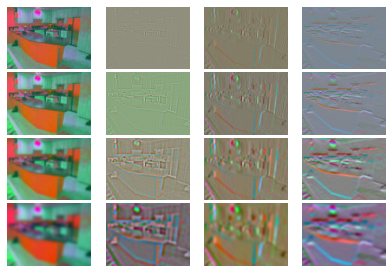

In [172]:
# Should have filters for at least 3 scales.

opts.filter_scales = [1, 2, 4, 8]
img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path) / 255.
filter_responses = extract_filter_responses(opts, img)
display_filter_responses(opts, filter_responses)

## Q1.2

In [173]:
def compute_dictionary_one_image(args):
    """
    Extracts a random subset of filter responses of an image and save it to disk
    This is a worker function called by compute_dictionary

    Your are free to make your own interface based on how you implement compute_dictionary
    """
    opts, idx, img_path = args
    # ----- TODO -----
    alpha = opts.alpha
    image = plt.imread(img_path)
    image = image.astype('float')/255
    filter_response = extract_filter_responses(opts, image)
    height, width, channels = filter_response.shape

    rand_pixels_heights = np.random.permutation(height)[:alpha] #Height coordinates of alpha many random pixels
    rand_pixels_widths = np.random.permutation(width)[:alpha] #Width coordinates of alpha many random pixels
    random_samples = np.zeros((alpha, channels))
    for i in range(alpha):
        h_ind = rand_pixels_heights[i]
        w_ind = rand_pixels_widths[i]
        random_samples[i,:] = filter_response[h_ind, w_ind, :]

    #Creating the temporary directory
    dir_path = './temporary'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    np.save(join(dir_path, str(idx) + '.npy'), random_samples)



def compute_dictionary(opts, n_worker=1):
    """
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * opts         : options
    * n_worker     : number of workers to process in parallel

    [saved]
    * dictionary : numpy.ndarray of shape (K,3F)
    """

    data_dir = opts.data_dir
    feat_dir = opts.feat_dir
    out_dir = opts.out_dir
    K = opts.K

    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    # ----- TODO -----
    #creating the paths for each file
    train_paths = [join(data_dir, name) for name in train_files]
    #train_paths = train_paths[:100]
    args = zip([opts for _ in range(len(train_paths))], range(len(train_paths)), train_paths)
    #I can't figure out how parallel processing works T_T
    #pool = multiprocessing.Pool(processes = n_worker)
    #pool.map(compute_dictionary_one_image, args)
    for idx, path in enumerate(train_paths):
        compute_dictionary_one_image((opts, idx, path))
    
    #Putting all of the responses back together now:

    responses = np.array([])
    for data in os.listdir('./temporary'):
        response = np.load(join('./temporary', data))
        responses = np.array(np.append(responses, response, axis = 0) if responses.shape[0] != 0 else response)
    print(responses.shape)

    kmeans = sklearn.cluster.KMeans(n_clusters = K).fit(responses)
    dictionary = kmeans.cluster_centers_
    print(dictionary.shape)
    np.save('dictionary.npy', dictionary)

    
    

 

In [174]:
n_cpu = get_num_CPU()
compute_dictionary(opts, n_worker=n_cpu)

(29425, 48)
(10, 48)


## Q1.3

The wordmap shows the contours in each image. Words change along the edges and tend to stay the same for homogenous regions.

In [175]:
def get_visual_words(opts, img, dictionary):
    """
    Compute visual words mapping for the given img using the dictionary of visual words.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)

    [output]
    * wordmap: numpy.ndarray of shape (H,W)
    """

    # ----- TODO -----
    height, width, _ = img.shape
    wordmap = np.zeros((height, width))
    #filter responses for img
    filter_responses = extract_filter_responses(opts, img)
    for h in range(height):
        for w in range(width):
            pixel = filter_responses[h, w,:]
            distances_from_dict = scipy.spatial.distance.cdist(np.array([pixel]), dictionary, 'euclidean')
            wordmap[h, w] = np.where(distances_from_dict == np.min(distances_from_dict))[1][0]
    return wordmap


In [176]:
dictionary = np.load(join(opts.out_dir, 'dictionary.npy'))

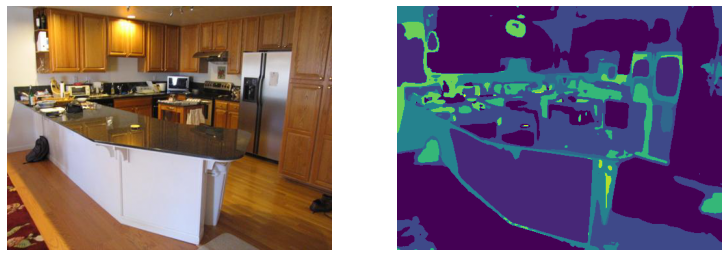

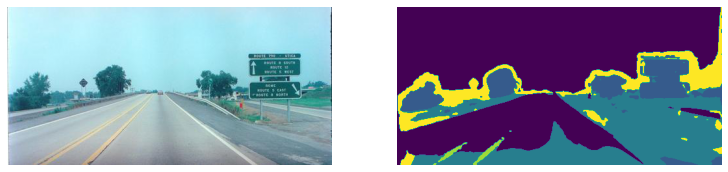

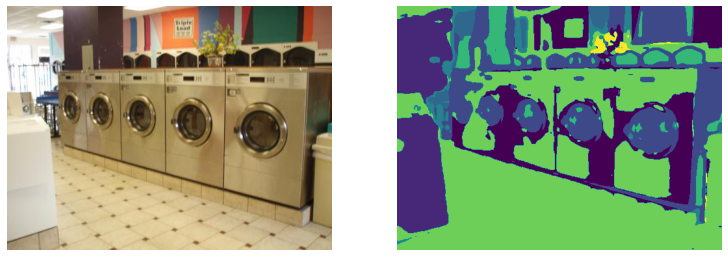

In [177]:
img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'highway/sun_ailjxpgyepocjdos.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'laundromat/sun_aabvooxzwmzzvwds.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)


## Q2.1

In [178]:
def get_feature_from_wordmap(opts, wordmap):
    '''
    Compute histogram of visual words.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist: numpy.ndarray of shape (K)
    '''

    K = opts.K
    # ----- TODO -----
    wordmap = wordmap.flatten()
    hist, _ = np.histogram(wordmap, bins = range(K+1), density = True)
    #L_1 normalization I think is just dividing by sum
    hist = hist/np.sum(hist)
    
    return hist

In [179]:
get_feature_from_wordmap(opts, wordmap)

array([1.50816000e-01, 1.18090667e-01, 1.80272000e-01, 1.71040000e-02,
       2.29173333e-02, 0.00000000e+00, 4.11466667e-02, 4.63749333e-01,
       1.06666667e-05, 5.89333333e-03])

## Q2.2



In [180]:
def get_feature_from_wordmap_SPM(opts, wordmap):
    """
    Compute histogram of visual words using spatial pyramid matching.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist_all: numpy.ndarray of shape (K*(4^L-1)/3)
    """

    K = opts.K
    L = opts.L
    # ----- TODO -----
    cells = int(2**L) # Number of cells in finest layer
    height, width  = wordmap.shape
    cell_height, cell_width = int(height//cells), int(width//cells)
    hist_all = np.empty((0, ), np.float)
    weight = 0.5
    cell_hist_arr = np.zeros((cells, cells, K))
    for i in range(cells):
        for j in range(cells):
            cell = wordmap[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
            cell_hist = get_feature_from_wordmap(opts, cell)
            cell_hist_arr[i, j, :] = cell_hist
    hist_all = np.append((cell_hist_arr*weight).flatten(), hist_all)


    #Doing the rest of the layers via aggregating the finest layer
    previous_hist = np.copy(cell_hist_arr)
    for l in range(L-1, -1, -1):
        cells = cells//2
        if l!=0:
            weight = weight//2
        #else:
        #    weight = 1
        layer_hist = np.zeros((cells, cells, K))
        for i in range(cells):
            for j in range(cells):
                layer_hist[i, j, :] = np.sum(previous_hist[i*2:(i+1)*2, j*2:(j+1)*2, :], axis = (0, 1))

        hist_all = np.append((layer_hist*weight).flatten(), hist_all)
        previous_hist = layer_hist
    

    hist_all = hist_all/np.sum(hist_all)            



    return hist_all

## Q2.3

In [181]:
def distance_to_set(word_hist, histograms):
    """
    Compute the distance between a histogram of visual words with all training image histograms.

    [input]
    * word_hist: numpy.ndarray of shape (K)
    * histograms: numpy.ndarray of shape (N,K)

    [output]
    * dists: numpy.ndarray of shape (N)
    """

    # ----- TODO -----
    
    
    return np.sum(np.minimum(word_hist, histograms), axis = 1)

## Q2.4

In [182]:
def get_image_feature(opts, img_path, dictionary):
    """
    Extracts the spatial pyramid matching feature.

    [input]
    * opts      : options
    * img_path  : path of image file to read
    * dictionary: numpy.ndarray of shape (K, 3F)


    [output]
    * feature: numpy.ndarray of shape (K)
    """

    # ----- TODO -----
    image = plt.imread(img_path).astype('float')/255
    wordmap = get_visual_words(opts, image, dictionary)
    feature = get_feature_from_wordmap_SPM(opts, wordmap)
    #feature = get_feature_from_wordmap(opts, wordmap)
    #print(idx)


    return feature

In [183]:
def build_recognition_system(opts, n_worker=1):
    """
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [saved]
    * features: numpy.ndarray of shape (N,M)
    * labels: numpy.ndarray of shape (N)
    * dictionary: numpy.ndarray of shape (K,3F)
    * SPM_layer_num: number of spatial pyramid layers
    """

    data_dir = opts.data_dir
    out_dir = opts.out_dir
    SPM_layer_num = opts.L

    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    train_labels = np.loadtxt(join(data_dir, "train_labels.txt"), np.int32)
    dictionary = np.load(join(out_dir, "dictionary.npy"))

    # ----- TODO -----
    train_paths = [join(data_dir, name) for name in train_files]
    args = zip([i for i in range(len(train_paths))], [opts for _ in train_paths], train_paths, [dictionary for _ in train_paths])
    #I just can't get multiprocessing to work for some reason. It's so much slower than just looping
    #pool = multiprocessing.Pool(n_worker)
    #features = pool.map(get_image_feature, args)
    features = np.array([])
    print(len(train_paths))
    for i in range(len(train_paths)):
    #for i in range(5):
        print(i)
        features_image = get_image_feature(opts, train_paths[i], dictionary)
        features = np.array(np.append(features, np.array([features_image]), axis = 0) if features.shape[0] != 0 else np.array([features_image]))
    print(features.shape)
    
    np.savez_compressed(join(out_dir, 'trained_system.npz'),
        features = features, 
        labels = train_labels, 
        dictionary = dictionary, 
        SPM_layer_num = SPM_layer_num)
    

    # example code snippet to save the learned system
    # np.savez_compressed(join(out_dir, 'trained_system.npz'),
    #     features=features,
    #     labels=train_labels,
    #     dictionary=dictionary,
    #     SPM_layer_num=SPM_layer_num,
    # )



In [184]:
build_recognition_system(opts, n_worker=n_cpu)


1177
0


<ipython-input-180-3c420ce47146>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hist_all = np.empty((0, ), np.float)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Q2.5

In [195]:
#I split this into two functions because I needed to debug without having to run through a huge amount of code everytime. 
def evaluate_recognition_system(opts, n_worker=1):
    """
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    """

    data_dir = opts.data_dir
    out_dir = opts.out_dir

    trained_system = np.load(join(out_dir, "trained_system.npz"))
    dictionary = trained_system["dictionary"]

    # using the stored options in the trained system instead of opts.py
    test_opts = copy(opts)
    test_opts.K = dictionary.shape[0]
    test_opts.L = trained_system["SPM_layer_num"]

    test_files = open(join(data_dir, "test_files.txt")).read().splitlines()
    test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32)

    # ----- TODO -----
    train_features = trained_system['features']
    train_labels = trained_system['labels']
    dictionary = trained_system['dictionary']
    SPM_layer_num = trained_system['SPM_layer_num']
    test_paths = [join(data_dir, name) for name in test_files]

    #Again tried to implement multiprocessing unsuccessfully
    print("test_features")
    test_features= np.array([])
    for i in range(len(test_labels)):
        test_features_image = get_image_feature(test_opts, test_paths[i], dictionary)
        test_features = np.array(np.append(test_features, np.array([test_features_image]), axis = 0) if test_features.shape[0] != 0 else np.array([test_features_image]))
        print(i)
    dimensions = 8
    conf = np.zeros((dimensions, dimensions))
    for i, features in enumerate(test_features):
        sim = distance_to_set(features, train_features)
        [idx] = np.where(sim == np.max(sim))
        prediction = train_labels[idx]
        label = test_labels[i]
        conf[label, prediction] += 1
        
    accuracy = np.diag(conf).sum()/conf.sum()
    return conf, accuracy

    #return train_features, test_features, train_labels, test_labels
    #This function now only returns the features and the actual accuracy, etc, is computed by a followup function.



In [196]:
#train_features, test_features, train_labels, test_labels = evaluate_recognition_system(opts, n_cpu)

In [197]:
#This function now calculates the desired accuracies and confusion tables. 
#def acc_conf(train_features, test_features, train_labels, test_labels):
#    dimensions = 8
#    conf = np.zeros((dimensions, dimensions))
#    for i, features in enumerate(test_features):
#        sim = distance_to_set(features, train_features)
#        [idx] = np.where(sim == np.max(sim))
#        prediction = train_labels[idx]
#        label = test_labels[i]
#        conf[label, prediction] += 1
#        
#    accuracy = np.diag(conf).sum()/conf.sum()
#    return conf, accuracy

In [198]:
#conf, accuracy = acc_conf(train_features, test_features, train_labels, test_labels)

In [199]:
conf, accuracy = evaluate_recognition_system(opts, n_cpu)

test_features


<ipython-input-180-3c420ce47146>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hist_all = np.empty((0, ), np.float)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [200]:
print("Accuracy:", accuracy)
classes = [
    "aquarium", "desert", "highway", "kitchen",
    "laundromat", "park", "waterfall", "windmill",
]
df = pd.DataFrame(conf, columns=classes)
df.insert(0, "", classes)
df

Accuracy: 0.545


,,aquarium,desert,highway,kitchen,laundromat,park,waterfall,windmill
0,aquarium,33.0,1.0,2.0,4.0,1.0,2.0,3.0,4.0
1,desert,0.0,28.0,7.0,6.0,4.0,0.0,2.0,3.0
2,highway,1.0,5.0,30.0,1.0,0.0,1.0,2.0,10.0
3,kitchen,4.0,3.0,2.0,31.0,7.0,1.0,1.0,1.0
4,laundromat,3.0,2.0,1.0,14.0,23.0,5.0,1.0,1.0
5,park,2.0,1.0,5.0,0.0,3.0,31.0,4.0,4.0
6,waterfall,6.0,0.0,2.0,1.0,6.0,11.0,21.0,3.0
7,windmill,3.0,8.0,6.0,0.0,1.0,5.0,6.0,21.0


## Q2.6

By referring to the confusion matrix, one can see that, for instance, the laundromat seems to be harder to correctly identifier, and are often confused with kitchens. This is due to similar looking textures and visual components in both, i.e, metallic, artificial structures in indoor settings. Similarly, we see that windmills and waterfalls are harder to classify as well. By inspecting the windmill dataset we see that they are often misclassified with highways- this is because most of the windmills are situated near a road itself; waterfalls are often misclassified as parks- which is expected due to an overlap in greenery (trees, etc) in both. 

Essentially whenever there is an overlap in the visual dictionary, we see a higher rate of misclassifications. Aquariums were the most well classified and of course have the most unique visual dictionary attached to them. 

## Q3.1

We'll try increasing $L$, increasing $K$ and increasing $\alpha$. Due to time constraints for running the program, I wasn't able to run all of these entirely before the assignment date. I am leaving the code though in hopes that I could get some partial credit. 

We expect these increases to correspond to increases in the accuracy- an increase in $L$ means a more refined spatial pyramid matching which is better at capturing 'semantic' meaning behind the images (since the spatial positioning of the image features is very important). An increase in $K$ increases the visual dictionary which allows for more finetuned classification- but only to an extent after which the clusters become too similar/start overfitting to be useful. Increasing $\alpha$ is like increasing our sample set but it comes with some pretty heavy runtime penalty. 


In [203]:
#Increase $L$
opts.L = 2
build_recognition_system(opts, n_worker=n_cpu)
conf, accuracy = evaluate_recognition_system(opts, n_cpu)
print(accuracy)


1177
0


<ipython-input-180-3c420ce47146>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hist_all = np.empty((0, ), np.float)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
#Increase $K$
opts.K = 20
compute_dictionary(opts, n_cpu)
dictionary = np.load(join(opts.out_dir, 'dictionary.npy'))
build_recognition_system(opts, n_worker=n_cpu)
conf, accuracy = evaluate_recognition_system(opts, n_cpu)
print(accuracy)

In [ ]:
opts.alpha = 50
compute_dictionary(opts, n_cpu)
dictionary = np.load(join(opts.out_dir, 'dictionary.npy'))
build_recognition_system(opts, n_worker = n_cpu)
conf, accuracy = evaluate_recognition_system(opts, n_cpu)
print(accuracy)

In [ ]:
print("Raw/Default Accuracy: %d", 0.545)
print("Accuracy with L = 2: %d", )
print("Accuracy with L =2, K = 20: %d", )
print("Accuracy with L = 2, K = 20, alpha = 50: %d", )

## Q3.2



## Q3.3 (Extra Credit)

In [ ]:
def compute_IDF(opts, n_worker=1):
    # YOUR CODE HERE
    pass

def evaluate_recognition_System_IDF(opts, n_worker=1):
    # YOUR CODE HERE
    pass